# Imports

In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score
from load_cifar_script import get_cifar10_data, get_cifar10_pretrained_models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

RNG = torch.Generator().manual_seed(42)

from copy import deepcopy
from typing import Callable
from tqdm.notebook import tqdm

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn import linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score

Running on device: CUDA


# Download Dataset and Pre-trained model


In [2]:
#Preprocess Cifar-10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Split Cifar-10 into Train-Val-Test Dataset
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)

test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)

test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# Forget and Retain Split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

100%|██████████| 170498071/170498071 [00:02<00:00, 59028341.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We'll now download the weights of the model trained in CIFAR-10 and load them in a Pytorch model. This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4. It was also trained using data augmentation. In particular, the transforms used to the data were:

```python
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```


In [3]:
# Download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

Files already downloaded and verified


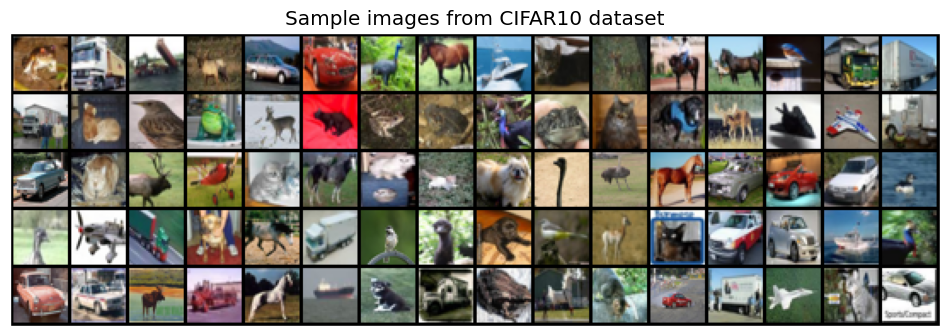

In [4]:
#Display Images of Dataset
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

# Model's Accuracy on the Train and Test set.


In [5]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


# Unlearning Algorithm

In [6]:
#Model 1

def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [7]:
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

ft_model = unlearning(ft_model, retain_loader, forget_loader, test_loader)

# Evaluate Unlearned Algorithm on Retain and Test Set

In [8]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

Retain set accuracy: 98.1%
Test set accuracy: 84.0%


# Losses of Pretrained Model on train and test set

In [9]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

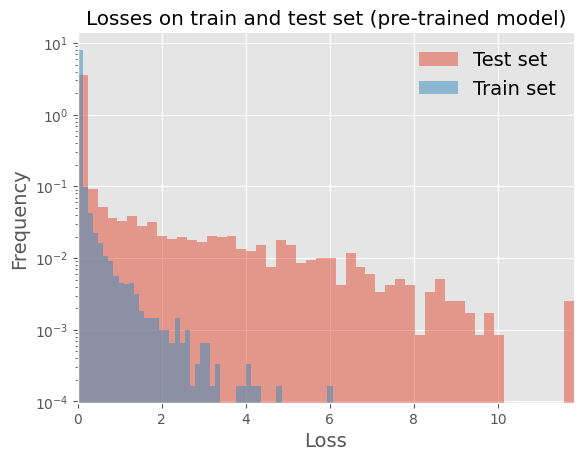

In [10]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

# MIA ( Membership Inference Attack)

In [11]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [12]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.576 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [13]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [14]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.509 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

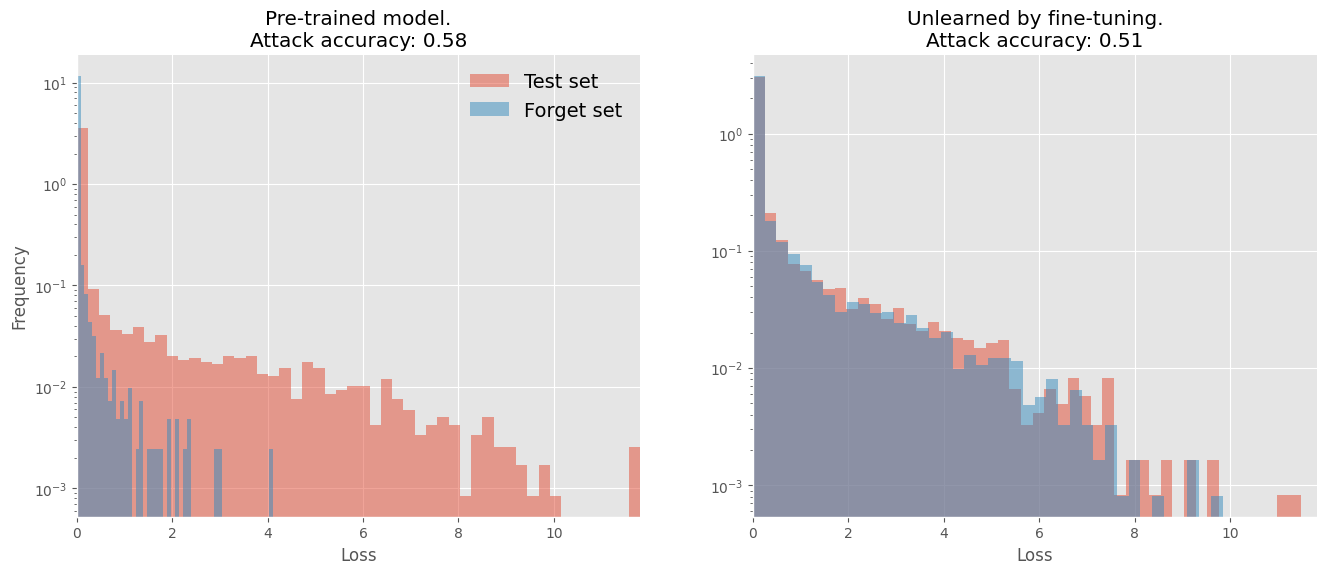

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

In [16]:
# download weights of a model trained exclusively on the retain set
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [17]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [18]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.500 on forgotten vs unseen images


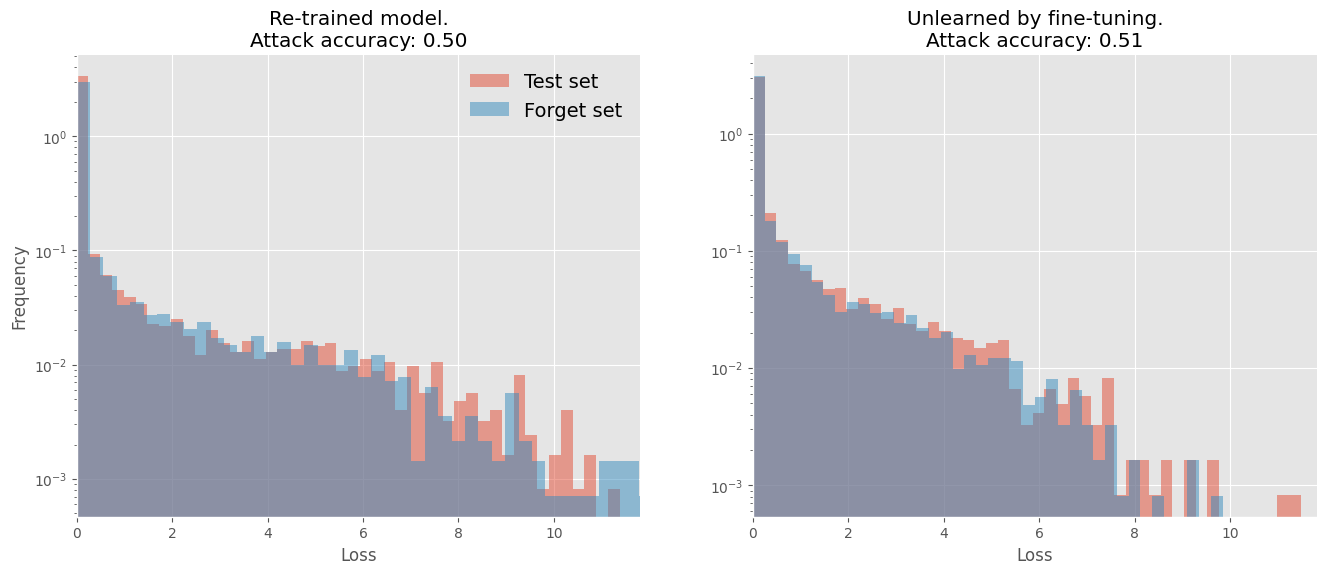

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

# Unlearning Score

## Define FPR and FNR

In [20]:
def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """

    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset, 
            batch_size=loader.batch_size, 
            shuffle=False, 
            num_workers=loader.num_workers)
    
    all_outputs = []
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)
        
        all_outputs.append(logits)
        
    return np.concatenate(all_outputs) # (len(loader.dataset), num_classes)


def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n


def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p


# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}

## Define Cross Entropy

In [21]:
def cross_entropy_f(x):
    # To ensure this function doesn't fail due to nans, find
    # all-nan rows in x and substitude them with all-zeros.
    x[np.all(np.isnan(x), axis=-1)] = np.zeros(x.shape[-1])
    
    pred = torch.tensor(np.nanargmax(x, axis = -1))
    x = torch.tensor(x)

    fn = nn.CrossEntropyLoss(reduction="none")
    
    return fn(x, pred).numpy()

## Define LRA and BTA

In [22]:
def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)
    
    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])
    
    return fpr, fnr


def best_threshold_attack(
        outputs_U: np.ndarray, 
        outputs_R: np.ndarray, 
        random_state: int = 0
    ) -> tuple[list[float], list[float]]:
    """Computes FPRs and FNRs for an attack that simply splits into 
    predicted positives and predited negatives based on any possible 
    single threshold.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
    Returns:
      fpr, fnr : list[float] * list[float]
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    N = len(outputs_U)
    
    fprs, fnrs = [], []
    for thresh in sorted(list(samples.squeeze())):
        ypred = (samples > thresh).astype("int")
        fprs.append(false_positive_rate(labels, ypred))
        fnrs.append(false_negative_rate(labels, ypred))
    
    return fprs, fnrs

In [23]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example, 
    given the FPRs and FNRs resulting from various attacks.
    
    The smaller epsilon is, the better the unlearning is.
    
    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example. 
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)
    
    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))
            
    return np.nanmax(per_attack_epsilon)


def bin_index_fn(
        epsilons: np.ndarray, 
        bin_width: float = 0.5, 
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def F(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees 
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)

## Define Forgetting Quality

In [24]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the 
      distribution of each model (N=512 in the case of the competition's leaderboard) 
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """
    
    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape
    
    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"
    
    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in pbar:
        pbar.set_description("Computing F...")
        
        sample_fprs, sample_fnrs = [], []
        
        for attack in attacks: 
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]
            
            fpr, fnr = attack(uls, rls)
            
            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)
        
        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)
        
    return F(np.array(epsilons))

## Define Unlearning Score = F * RA_ratio * TA_ratio

In [25]:
def score_unlearning_algorithm(
        data_loaders: dict, 
        pretrained_models: dict, 
        unlearning: Callable, 
        n: int = 10,
        delta: float = 0.01,
        f: Callable = cross_entropy_f,
        attacks: list[Callable] = [best_threshold_attack, logistic_regression_attack]
        ) -> dict:
    
    # n=512 in the case of unlearn and n=1 in the
    # case of retrain, since we are only provided with one retrained model here

    retain_loader = data_loaders["retain"]
    forget_loader = data_loaders["forget"]
    val_loader = data_loaders["validation"]
    test_loader = data_loaders["testing"]

    original_model = pretrained_models["original"]
    rt_model = pretrained_models["retrained"]

    outputs_U = []
    retain_accuracy = []
    test_accuracy = []
    forget_accuracy = []

    pbar = tqdm(range(n))
    for i in pbar:
        
        # unlearned model
        
        u_model = deepcopy(original_model)
        # Execute the unlearing routine. This might take a few minutes.
        # If run on colab, be sure to be running it on  an instance with GPUs

        pbar.set_description(f"Unlearning...")
        u_model = unlearning(u_model, retain_loader, forget_loader, val_loader)

        outputs_Ui = compute_outputs(u_model, forget_loader) 
        # The shape of outputs_Ui is (len(forget_loader.dataset), 10)
        # which for every datapoint is being cast to a scalar using the funtion f
        outputs_U.append( f(outputs_Ui) )

        pbar.set_description(f"Computing retain accuracy...")
        retain_accuracy.append(accuracy(u_model, retain_loader))

        pbar.set_description(f"Computing test accuracy...")
        test_accuracy.append(accuracy(u_model, test_loader))

        pbar.set_description(f"Computing forget accuracy...")
        forget_accuracy.append(accuracy(u_model, forget_loader))


    outputs_U = np.array(outputs_U) # (n, len(forget_loader.dataset))

    assert outputs_U.shape == (n, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."

    RAR = accuracy(rt_model, retain_loader)
    TAR = accuracy(rt_model, test_loader)
    FAR = accuracy(rt_model, forget_loader)

    RAU = np.mean(retain_accuracy)
    TAU = np.mean(test_accuracy)
    FAU = np.mean(forget_accuracy)

    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR

    # need to fake this a little because we only have one retrain model
    scale = np.std(outputs_U) / 10.
    outputs_Ri = compute_outputs(rt_model, forget_loader) #(len(forget_loader.dataset), 10) 
    outputs_Ri = np.expand_dims(outputs_Ri, axis=0)
    outputs_Ri = np.random.normal(
        loc=outputs_Ri, scale=scale, size=(n, *outputs_Ri.shape[-2:]))
    
    outputs_R = np.array([ f( oRi ) for oRi in outputs_Ri ])

    np.save("outputs_U.npy", outputs_U)
    np.save("outputs_R.npy", outputs_R)
    
    f = forgetting_quality(
        outputs_U, 
        outputs_R,
        attacks=attacks,
        delta=delta)

    return {
        "total_score": f * RA_ratio * TA_ratio,
        "F": f,
        "unlearn_retain_accuracy": RAU,
        "unlearn_test_accuracy": TAU, 
        "unlearn_forget_accuracy": FAU,
        "retrain_retain_accuracy": RAR,
        "retrain_test_accuracy": TAR, 
        "retrain_forget_accuracy": FAR,
        "retrain_outputs": outputs_R,
        "unlearn_outputs": outputs_U
    }

In [26]:
data_loaders = get_cifar10_data()
pretrained_models = get_cifar10_pretrained_models(device='cuda')

Files already downloaded and verified
Files already downloaded and verified


In [27]:
ret = score_unlearning_algorithm(data_loaders, pretrained_models, unlearning)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [28]:
ret

{'total_score': 0.10221610532397477,
 'F': 0.1086216796875,
 'unlearn_retain_accuracy': 0.9847600000000002,
 'unlearn_test_accuracy': 0.8365600000000001,
 'unlearn_forget_accuracy': 0.8554,
 'retrain_retain_accuracy': 0.9952666666666666,
 'retrain_test_accuracy': 0.8796,
 'retrain_forget_accuracy': 0.882,
 'retrain_outputs': array([[3.86868051e-01, 6.89362661e-03, 5.34266137e-05, ...,
         1.40196772e-01, 4.67950202e-01, 2.17407301e-03],
        [3.85848201e-01, 6.90706380e-03, 5.30408011e-05, ...,
         1.37430385e-01, 4.52607387e-01, 2.25901937e-03],
        [3.81027234e-01, 6.61560100e-03, 5.40018982e-05, ...,
         1.38345638e-01, 4.64353911e-01, 2.12445903e-03],
        ...,
        [3.84398991e-01, 6.66400222e-03, 5.31849058e-05, ...,
         1.41813254e-01, 4.58918932e-01, 2.20480444e-03],
        [3.94987590e-01, 6.79971275e-03, 5.36234336e-05, ...,
         1.43451239e-01, 4.67349156e-01, 2.24344405e-03],
        [3.95581523e-01, 6.57956872e-03, 5.33810515e-05, ...,

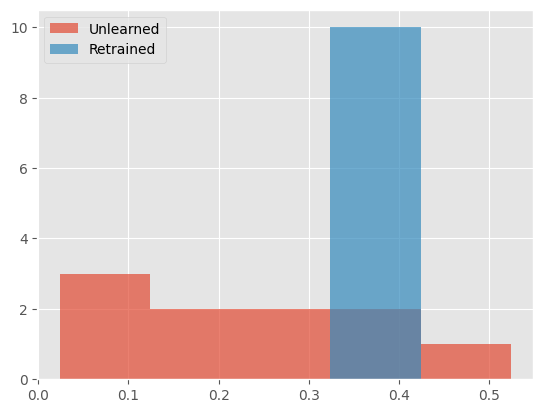

In [29]:
udata = ret["unlearn_outputs"][:,0]
rdata = ret["retrain_outputs"][:,0]
data = np.array([udata, rdata])

bins = np.arange(np.min(data), np.max(data) + 0.1, 0.1)

plt.hist(udata, bins=bins, alpha=0.7, label="Unlearned")
plt.hist(rdata, bins=bins, alpha=0.7, label="Retrained")

plt.legend()
plt.show()